In [1]:
from functools import partial
from os.path import isfile
import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import torch.nn.functional as F
import umap
import h5py


from astropt.local_datasets import GalaxyImageDataset
from astropt.model_utils import load_astropt


/global/homes/a/ashodkh/.conda/envs/my_torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# set up HF galaxies in test set to be processed
def normalise(x):
    std, mean = torch.std_mean(x, dim=1, keepdim=True)
    x = (x - mean) / (std + 1e-8)      
    return x

def data_transforms():
    transform = transforms.Compose(
        [
            transforms.Lambda(normalise),
        ]
    )
    return transform

def _process_galaxy_wrapper(idx, func):
    """This function ensures that the image is tokenised in the same way as
    the pre-trained model is expecting"""
    galaxy = torch.from_numpy(np.array(idx["hsc_images"]).swapaxes(0, 2)).to(float)
    galaxy = F.interpolate(galaxy[None,:,:,:], size=(512, 512), mode='bilinear', align_corners=False).squeeze() 
    galaxy = func(galaxy).to(torch.float)
    galaxy_positions = torch.arange(0, len(galaxy), dtype=torch.long)
    mag_g = idx['mag_model_hsc-g']
    return {
        "images": galaxy,
        "images_positions": galaxy_positions,
        'mag_model_hsc-g': mag_g,
    }

In [4]:
model = load_astropt("Smith42/astroPT_v2.0", path="astropt/015M")
galproc = GalaxyImageDataset(
    None,
    spiral=True,
    transform={"images": data_transforms()},
    modality_registry=model.modality_registry,
)

Model type: native
Total parameters: 14.55M
Trainable parameters: 14.55M
Error(s) in loading state_dict for GPT:
	Missing key(s) in state_dict: "encoders.images.c_fc.weight", "encoders.images.c_proj.weight", "decoders.images.c_fc.weight", "decoders.images.c_proj.weight", "embedders.images.wpe.weight". 
	Unexpected key(s) in state_dict: "lm_head.images.c_fc.weight", "lm_head.images.c_proj.weight", "transformer.wte.images.c_fc.weight", "transformer.wte.images.c_proj.weight", "transformer.wpe.images.wpe.weight". 
Assuming we are loading a version of AstroPT < 3.0, so altering state dict key names to fit...
model loaded successfully from Smith42/astroPT_v2.0/astropt/015M
args: {'n_layer': 6, 'n_head': 8, 'n_embd': 384, 'n_chan': 3, 'block_size': 1024, 'dropout': 0.0, 'modalities': [ModalityConfig(name='images', input_size=768, pos_input_size=1, patch_size=16, embed_pos=True, vocab_size=0, loss_weight=1.0)], 'attn_type': 'causal'}


In [8]:
batch_size = 32
ds = (
        load_dataset("Ashodkh/cosmosweb-hsc-jwst-high-snr-pil", split="train", streaming=True)
        .select_columns(("hsc_images", 'mag_model_hsc-g'))
        .filter(lambda idx: idx['mag_model_hsc-g'] is not None)
        .map(partial(_process_galaxy_wrapper, func=galproc.process_galaxy))
        .with_format("torch")
        .take(
            2000 + batch_size
        )  # use the first 100 examples of our dataset to shorten total inference time
    )
dl = iter(
    DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0,
        shuffle=False
    )
)

In [9]:
for data in dl:
    test_data = data
    break

In [10]:
test_data.keys()

dict_keys(['hsc_images', 'mag_model_hsc-g', 'images', 'images_positions'])

In [11]:
embeddings = []
for data in tqdm(dl):
    embeddings.append(model.generate_embeddings(data)["images"].detach().numpy())
    

0it [00:00, ?it/s]

torch.Size([32, 1024, 768])


1it [00:15, 15.75s/it]

torch.Size([32, 1024, 768])


2it [00:30, 14.98s/it]

torch.Size([32, 1024, 768])


3it [00:46, 15.78s/it]

torch.Size([32, 1024, 768])


4it [01:01, 15.43s/it]

torch.Size([32, 1024, 768])


5it [01:17, 15.64s/it]

torch.Size([32, 1024, 768])


6it [01:34, 15.98s/it]

torch.Size([32, 1024, 768])


7it [01:50, 15.83s/it]

torch.Size([32, 1024, 768])


8it [02:06, 16.02s/it]

torch.Size([32, 1024, 768])


9it [02:21, 15.85s/it]

torch.Size([32, 1024, 768])


10it [02:38, 15.93s/it]

torch.Size([32, 1024, 768])


11it [02:51, 15.33s/it]

torch.Size([32, 1024, 768])


12it [03:07, 15.27s/it]

torch.Size([32, 1024, 768])


13it [03:21, 14.87s/it]

torch.Size([32, 1024, 768])


14it [03:35, 14.69s/it]

torch.Size([32, 1024, 768])


15it [03:48, 14.10s/it]

torch.Size([32, 1024, 768])


16it [04:01, 13.85s/it]

torch.Size([32, 1024, 768])


17it [04:14, 13.74s/it]

torch.Size([32, 1024, 768])


18it [04:28, 13.70s/it]

torch.Size([32, 1024, 768])


19it [04:42, 13.66s/it]

torch.Size([32, 1024, 768])


20it [04:58, 14.50s/it]

torch.Size([32, 1024, 768])


21it [05:13, 14.80s/it]

torch.Size([32, 1024, 768])


22it [05:28, 14.81s/it]

torch.Size([32, 1024, 768])


23it [05:42, 14.59s/it]

torch.Size([32, 1024, 768])


24it [05:56, 14.37s/it]

torch.Size([32, 1024, 768])


25it [06:10, 14.13s/it]

torch.Size([32, 1024, 768])


26it [06:25, 14.41s/it]

torch.Size([32, 1024, 768])


27it [06:40, 14.51s/it]

torch.Size([32, 1024, 768])


28it [06:55, 14.74s/it]

torch.Size([32, 1024, 768])


29it [07:10, 14.98s/it]

torch.Size([32, 1024, 768])


30it [07:26, 15.25s/it]

torch.Size([32, 1024, 768])


31it [07:42, 15.31s/it]

torch.Size([32, 1024, 768])


32it [07:56, 14.92s/it]

torch.Size([32, 1024, 768])


33it [08:10, 14.72s/it]

torch.Size([32, 1024, 768])


34it [08:24, 14.54s/it]

torch.Size([32, 1024, 768])


35it [08:38, 14.29s/it]

torch.Size([32, 1024, 768])


36it [08:53, 14.60s/it]

torch.Size([32, 1024, 768])


37it [09:08, 14.54s/it]

torch.Size([32, 1024, 768])


38it [09:22, 14.48s/it]

torch.Size([32, 1024, 768])


39it [09:35, 14.10s/it]

torch.Size([32, 1024, 768])


40it [09:48, 13.87s/it]

torch.Size([32, 1024, 768])


41it [10:03, 14.15s/it]

torch.Size([32, 1024, 768])


42it [10:17, 14.05s/it]

torch.Size([32, 1024, 768])


43it [10:32, 14.20s/it]

torch.Size([32, 1024, 768])


44it [10:44, 13.72s/it]

torch.Size([32, 1024, 768])


45it [10:59, 14.08s/it]

torch.Size([32, 1024, 768])


46it [11:14, 14.31s/it]

torch.Size([32, 1024, 768])


47it [11:29, 14.38s/it]

torch.Size([32, 1024, 768])


48it [11:43, 14.30s/it]

torch.Size([32, 1024, 768])


49it [11:57, 14.21s/it]

torch.Size([32, 1024, 768])


50it [12:10, 13.94s/it]

torch.Size([32, 1024, 768])


51it [12:24, 13.91s/it]

torch.Size([32, 1024, 768])


52it [12:40, 14.48s/it]

torch.Size([32, 1024, 768])


53it [12:55, 14.64s/it]

torch.Size([32, 1024, 768])


54it [13:10, 14.83s/it]

torch.Size([32, 1024, 768])


55it [13:24, 14.70s/it]

torch.Size([32, 1024, 768])


56it [13:40, 14.99s/it]

torch.Size([32, 1024, 768])


57it [13:54, 14.85s/it]

torch.Size([32, 1024, 768])


58it [14:09, 14.71s/it]

torch.Size([32, 1024, 768])


59it [14:24, 14.81s/it]

torch.Size([32, 1024, 768])


60it [14:40, 15.10s/it]

torch.Size([32, 1024, 768])


61it [14:56, 15.38s/it]

torch.Size([32, 1024, 768])


62it [15:13, 15.83s/it]

torch.Size([16, 1024, 768])


63it [15:20, 14.62s/it]


In [12]:
embeddings = np.vstack(embeddings)


In [13]:
embeddings.shape

(2000, 384)

In [14]:
reducer = umap.UMAP(n_components=2)
umap_embeddings = reducer.fit_transform(embeddings)


In [15]:
file_path = '/global/cfs/cdirs/m4236/cosmosweb/catalogs/hsc_jwst_matched_with_images_high_snr'
f = h5py.File(file_path, 'r')

list(f.keys())

['Confidence_level',
 'bulge_radius',
 'dec',
 'dec_specz',
 'disk_radius',
 'flux_err-cal_model_cfht-u',
 'flux_err-cal_model_f115w',
 'flux_err-cal_model_f150w',
 'flux_err-cal_model_f277w',
 'flux_err-cal_model_f444w',
 'flux_err-cal_model_hsc-g',
 'flux_err-cal_model_hsc-i',
 'flux_err-cal_model_hsc-r',
 'flux_err-cal_model_hsc-y',
 'flux_err-cal_model_hsc-z',
 'flux_model_cfht-u',
 'flux_model_f115w',
 'flux_model_f150w',
 'flux_model_f277w',
 'flux_model_f444w',
 'flux_model_hsc-g',
 'flux_model_hsc-i',
 'flux_model_hsc-r',
 'flux_model_hsc-y',
 'flux_model_hsc-z',
 'hsc_images',
 'id_specz_khostovan25',
 'jwst_images',
 'lephare_photozs',
 'lp_age',
 'lp_mass',
 'lp_sfr',
 'lp_ssfr',
 'lp_type',
 'lp_zpdf_l68',
 'lp_zpdf_u68',
 'mag_model_cfht-u',
 'mag_model_f115w',
 'mag_model_f150w',
 'mag_model_f277w',
 'mag_model_f444w',
 'mag_model_hsc-g',
 'mag_model_hsc-i',
 'mag_model_hsc-r',
 'mag_model_hsc-y',
 'mag_model_hsc-z',
 'photoz',
 'ra',
 'ra_specz',
 'specz']

ValueError: 'c' argument has 68 elements, which is inconsistent with 'x' and 'y' with size 2000.

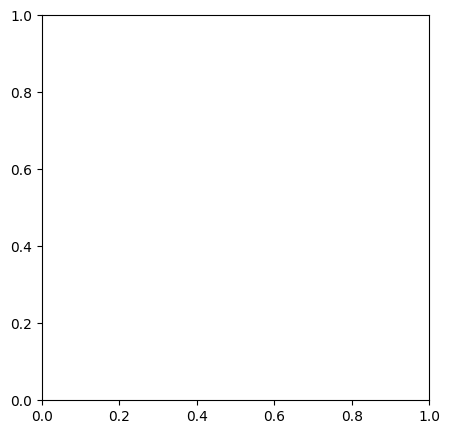

In [16]:
fig, ax = plt.subplots(figsize=(5,5))

sd = ax.scatter(umap_embeddings[:,0], umap_embeddings[:,1], c=f['mag_model_hsc-g'][:2000], s=5, vmin=22, vmax=26, cmap='inferno');
ax.set_title('redshift')
fig.colorbar(sd, ax=ax)


In [ ]:
f['hsc_images'].shape